In [90]:
from ncbiumls.authorization import authorization
from ncbiumls.access import UMLS, CUI
from time import sleep
from lxml import html
import pandas as pd
import numpy as np
import requests
import json
import copy
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [204]:
def read_data(normalized=False):
    tmp_data = {}
    # Read data from json
    for i in os.listdir('json/'):
        if i.startswith('1') or i.startswith('2'):
            year = int(i.split('.')[0])
            with open('json/{}'.format(i)) as data_file:
                tmp_data[year] = json.load(data_file)
                if normalized:
                    for ttype in ['chemicals', 'mesh_titles']:
                        for key, val in tmp_data[year][ttype].items():
                            tmp_data[year][ttype][key] = val / tmp_data[year]['count_articles']
    return tmp_data


def get_sorted(p_dict):
    return sorted(p_dict.items(), key=lambda x: x[1], reverse=True)


def dump_csv(p_dict, filename):
    to_print = []
    for y in range(1990, 2018):
        tmp = get_sorted(p_dict[y]['chemicals'])
        for word, freq in tmp:
            for n in range(freq):
                to_print.append(word)

    with open(filename, 'w') as ff:
        ff.write('; '.join(list(map(lambda x: x.replace(' ', '_'), to_print))))
        
        
def dump_csv_freq(p_dict, filename):
    to_print = []

    for y in [2000, 2005, 2015]:
        tmp = get_sorted(p_dict[y]['chemicals'])
        for word, freq in tmp:
                to_print.append(word.replace(' ', '_').replace(',','_'))
                to_print.append('; ')
                to_print.append(str(freq))
                to_print.append('\n')

    with open(filename, 'w') as ff:
        ff.write(''.join(to_print))
        
        
def count_terms():
    # Sum of terms per year during 27 years
    res = 0

    for y in range(1990, 2018):
        res += len(data[y]['chemicals'].items()) + len(data[y]['mesh_titles'].items())

    return res


def dump_topn_mesh_titles(p_dict, filename, n=100):
    assert(n <= len(p_dict))
    with open(filename, 'w') as f:
        f.write('\n'.join(list(map(lambda x: x[0], get_sorted(p_dict['mesh_titles'])[:n]))))
        
        
def dump_topn_chems(p_dict, filename, n=100):
    assert(n <= len(p_dict))
    with open(filename, 'w') as f:
        f.write('\n'.join(list(map(lambda x: x[0], get_sorted(p_dict['chemicals'])[:n]))))
        
        
def get_topn_terms(p_dict, n=100):
    """
    pdict - data[2009]['mesh_titles']
    """
    return list(map(lambda x: x[0], get_sorted(p_dict)[:100]))


def draw_articles_plot(p_dict):
    to_draw = []
    inxs = []

    for i in range(1990, 2016):
        if i in p_dict:
            tmp = p_dict[i]['count_articles']
            to_draw.append(tmp)
            inxs.append(i)

    plt.figure()
    plt.scatter(inxs, to_draw)
    plt.xlabel('Year')
    plt.title('Number of Articles per year')
    plt.show()
    
    
def get_through_years(input_data, substance):
    indexes = []
    to_draw = []
    for year in range(1990, 2016):
        if year in input_data and substance in input_data[year]['chemicals']:
            tmp = input_data[year]['chemicals'][substance]
            to_draw.append(tmp)
            indexes.append(year)
    return indexes, to_draw

    
def draw_plot(input_data, term, save=''):
    inxs, to_draw = get_through_years(input_data, term)

    plt.figure()
    plt.title(term)
    plt.xlabel('Year')
    plt.xlim((1989, 2016))
    plt.scatter(inxs, to_draw)
    if save != '':
        plt.savefig(save)
        

def clean_data(input_data, remove_list):
    p_data = copy.deepcopy(input_data)
    for rem in remove_list:
        for year in range(1990, 2018):
            if rem in p_data[year]['chemicals']:
                p_data[year]['chemicals'].pop(rem)
            if rem in p_data[year]['mesh_titles']:
                p_data[year]['mesh_titles'].pop(rem)
    return p_data


def get_dict_of_topn(input_data, n=12):
    dict_of_topn = {}
    for year in range(1990, 2016):
        dict_of_topn[year] = sorted(list(zip(input_data[year]['chemicals'].keys(),\
                                             input_data[year]['chemicals'].values())), \
                                    key=lambda x: x[1], reverse=True)[:n]
    return dict_of_topn


def topn_chems_by_year(input_data, p_n=5):
    for year in [1990, 2000, 2010, 2015]:
        print("Year: {}".format(year))
        print('-----')
        for inst in get_dict_of_topn(input_data, n=p_n)[year]:
            print(inst)
        print('########')
        print()
        
        
def replaced(input_data, replace_list):
    """REPLACE:
    app protein, human --with--> amyloid beta-protein precursor
    psen1 protein, human --with--> presenilin-1
    psen2 protein, human --with--> presenilin-2
    """
    p_data = copy.deepcopy(input_data)
    for from_term, to_term in replace_list:
        for y in range(1990, 2018):
            if from_term in p_data[y]['mesh_titles'] and to_term in p_data[y]['mesh_titles']:
                p_data[y]['mesh_titles'][to_term] += p_data[y]['mesh_titles'][from_term]
                p_data[y]['mesh_titles'].pop(from_term)
            if from_term in p_data[y]['chemicals'] and to_term in p_data[y]['chemicals']:
                p_data[y]['chemicals'][to_term] += p_data[y]['chemicals'][from_term]
                p_data[y]['chemicals'].pop(from_term)
    return p_data


def plot_every_k_year_topn(input_data, p_n=5, save_figs=False):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'r--', 'g--', 'b--']

    for year in [1990, 2000, 2010, 2015]:
        c = 0
        fig = plt.figure(figsize=(5,7))

        ax = fig.add_subplot(111)

        tuples = get_dict_of_topn(input_data, n=p_n)[year]
        instances = list(map(lambda x: x[0], tuples))
        for inst in instances:
            inxs, to_draw = get_through_years(input_data, inst)

            ax.plot(inxs, to_draw, colors[c], label=inst)
            c += 1

        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.4,1))

        ax.grid('on')
        ax.text(1.5, 1, 'Year: {}'.format(year),
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes, fontsize=12)
        
        axis = plt.axis()
        plt.vlines(year, axis[2], axis[3], linewidth=10, colors='yellow', alpha=0.5)
        plt.xlabel('Year')
        plt.ylabel('Number of Articles')
        if save_figs:
            fig.savefig('images/trend_in_years/year_{}'.format(year), bbox_inches='tight')
        plt.show()
        

def remove_bad_titles(input_data):
    
    ans = copy.deepcopy(input_data)
    
    def is_bad(title):
        if title.endswith('s'):
            return True
        if 'proteins' in title:
            return True
        return False

    for year in ans:
        for typ in ['chemicals', 'mesh_titles']:
            keys = list(ans[year][typ].keys())
            for term in keys:
                if is_bad(term):
                    ans[year][typ].pop(term)
    return ans

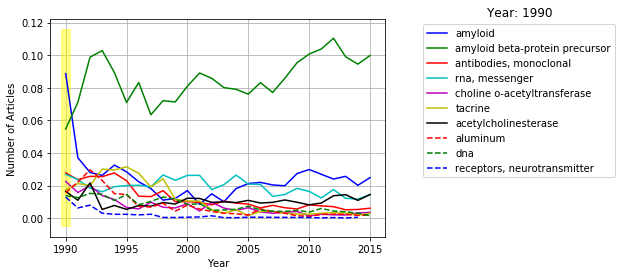

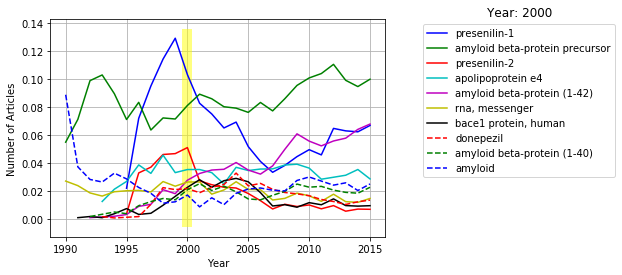

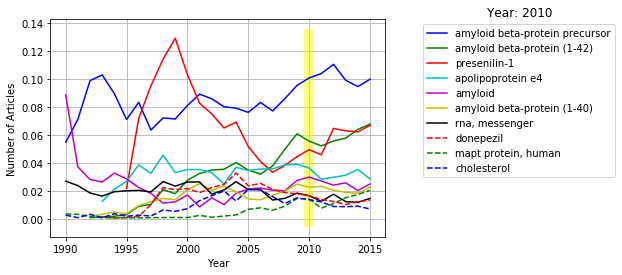

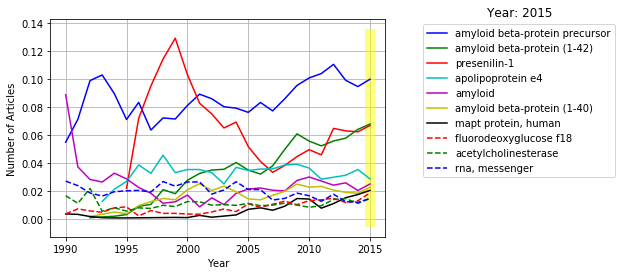

In [205]:
plot_every_k_year_topn(good_data, 10, True)

In [191]:
data = read_data(True)

rm_list = ['a', 'l', 'v', 'n', 't', ']', '[', 'o', 'i', 'b', 'e', ' ']

cl_data = clean_data(data, rm_list)

to_replace = [('app protein, human', 'amyloid beta-protein precursor'), \
              ('psen1 protein, human', 'presenilin-1'), \
              ('psen2 protein, human', 'presenilin-2')]

repl_data = replaced(cl_data, to_replace)
good_data = remove_bad_titles(repl_data)

print('Done!')

Done!


In [192]:
topn_chems_by_year(repl_data, p_n=10)

Year: 1990
-----
('amyloid', 0.08869565217391304)
('amyloid beta-peptides', 0.06173913043478261)
('protein precursors', 0.06086956521739131)
('amyloid beta-protein precursor', 0.05478260869565217)
('nerve tissue proteins', 0.0408695652173913)
('tau proteins', 0.034782608695652174)
('microtubule-associated proteins', 0.03391304347826087)
('antibodies, monoclonal', 0.02782608695652174)
('rna, messenger', 0.026956521739130435)
('choline o-acetyltransferase', 0.022608695652173914)
########

Year: 2000
-----
('amyloid beta-peptides', 0.1357658039881205)
('presenilin-1', 0.103097157403479)
('apolipoproteins e', 0.09461179465422147)
('amyloid beta-protein precursor', 0.08103521425540942)
('membrane proteins', 0.07212558336868902)
('cholinesterase inhibitors', 0.05854900296987696)
('peptide fragments', 0.056851930420025454)
('tau proteins', 0.051336444633008065)
('presenilin-2', 0.050912176495545185)
('apolipoprotein e4', 0.035214255409418756)
########

Year: 2010
-----
('amyloid beta-peptides

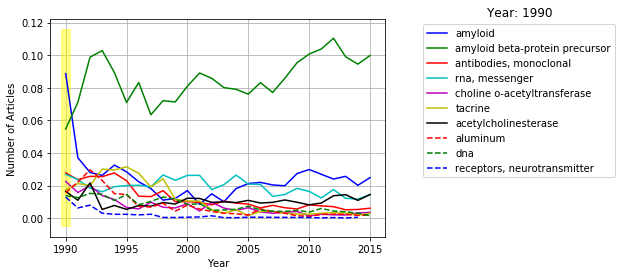

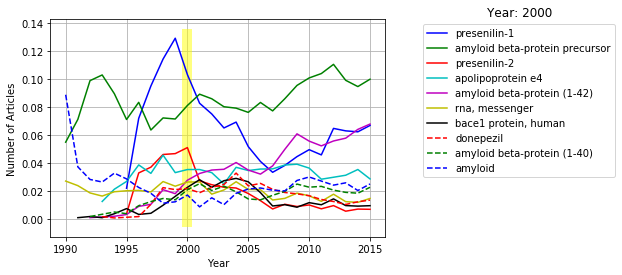

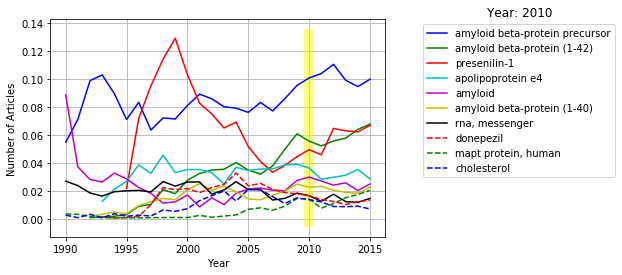

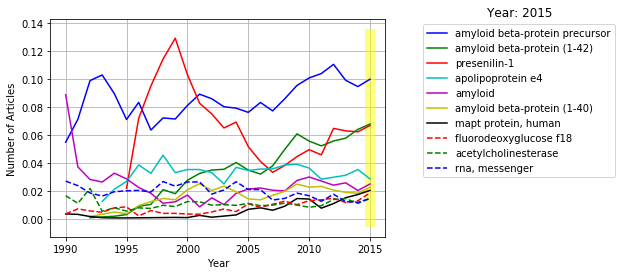

In [199]:
plot_every_k_year_topn(good_data, 10, True)

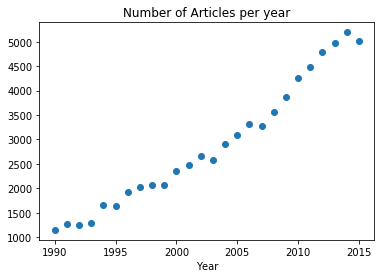

250923


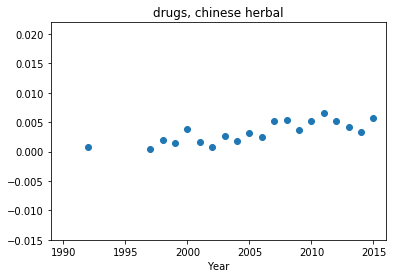

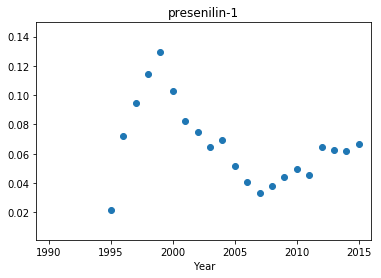

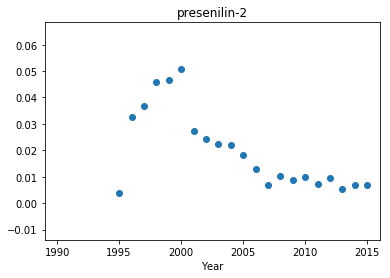

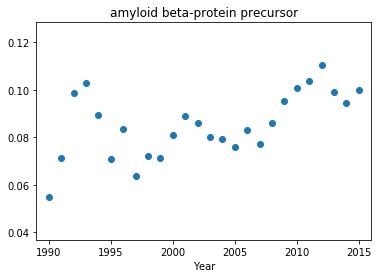

In [196]:
draw_articles_plot(good_data)
print(count_terms())
draw_plot(good_data, 'drugs, chinese herbal', 'ch_herbal.png')

draw_plot(good_data,'presenilin-1')
draw_plot(good_data, 'presenilin-2')
draw_plot(good_data, 'amyloid beta-protein precursor')

# Some actions with DataFrames and the file output_cleaned.csv

In [212]:
def get_df(filename):
    df = pd.read_csv(filename, sep=';', header=None)
    df = df.dropna()
    return df

def get_dict_of_topn(df, n=12):
    tmpdf = df.groupby(0).head(n)
    dict_of_topn = {}
    for y, inst in zip(tmpdf.reset_index(drop=True)[0].values, tmpdf.reset_index(drop=True)[1].values):
        if int(y) not in dict_of_topn:
            dict_of_topn[int(y)] = []
        dict_of_topn[int(y)].append(inst)
    return dict_of_topn

df = get_df('output_cleaned.csv')
df.head()

,0,1,2,3
0,1990.0,amyloid beta-protein precursor,0.054783,"['Amino Acid, Peptide, or Protein']"
1,1990.0,tacrine,0.017391,-
2,1990.0,acetylcholinesterase,0.016522,"['Amino Acid, Peptide, or Protein', 'Enzyme', ..."
3,1990.0,aluminum,0.015652,-
4,1990.0,physostigmine,0.010435,-


In [213]:
df[(1995.0 == df[0]) & ('presenilin-1' == df[1])]

,0,1,2,3
210,1995.0,presenilin-1,0.010922,"['Amino Acid, Peptide, or Protein', 'Biologica..."
211,1995.0,presenilin-1,0.010922,"['Amino Acid, Peptide, or Protein', 'Biologica..."


In [214]:
term_list = ['presenilin-1', 'presenilin-2', 'amyloid beta-protein precursor']
for y in range(1990, 2018):
    for term in term_list:
        ind_list = df[(y == df[0]) & (term == df[1])].index.tolist()
        assert(len(ind_list) < 3)
        if len(ind_list) == 2:
            ind1 = ind_list[0]
            ind2 = ind_list[1]
            add_value = df.ix[ind1].tolist()[2]
            old_value = df.ix[ind2].tolist()[2]
            df = df.set_value(ind2, 2, old_value + add_value)
            df = df.drop(ind1)

In [215]:
df[(1995.0 == df[0]) & ('presenilin-1' == df[1])]

,0,1,2,3
211,1995.0,presenilin-1,0.021844,"['Amino Acid, Peptide, or Protein', 'Biologica..."


In [217]:
sorted(list(zip(data[1990]['chemicals'].keys(), data[1990]['chemicals'].values())), key=lambda x: x[1], reverse=True)

[('amyloid', 0.08869565217391304),
 ('amyloid beta-peptides', 0.06173913043478261),
 ('protein precursors', 0.06086956521739131),
 ('amyloid beta-protein precursor', 0.05478260869565217),
 ('nerve tissue proteins', 0.0408695652173913),
 ('tau proteins', 0.034782608695652174),
 ('microtubule-associated proteins', 0.03391304347826087),
 ('antibodies, monoclonal', 0.02782608695652174),
 ('rna, messenger', 0.026956521739130435),
 ('choline o-acetyltransferase', 0.022608695652173914),
 ('neurotransmitter agents', 0.02),
 ('tacrine', 0.017391304347826087),
 ('nerve growth factors', 0.017391304347826087),
 ('protease inhibitors', 0.017391304347826087),
 ('acetylcholinesterase', 0.01652173913043478),
 ('aluminum', 0.01565217391304348),
 ('dna', 0.01391304347826087),
 ('receptors, neurotransmitter', 0.013043478260869565),
 ('glutamates', 0.01217391304347826),
 ('aminoacridines', 0.01217391304347826),
 ('epitopes', 0.011304347826086957),
 ('biomarkers', 0.011304347826086957),
 ('glial fibrillary

In [12]:
# def get_dict_of_topn(df, n=12):
#     dict_of_topn = {}
#     for year in range(1990, 2016):
#         dict_of_topn[year] = sorted(list(map(lambda x: tuple(x), \
#                                          df[df[0] == year][[1, 2]].values)),\
#                                          key=lambda x: x[1], reverse=True)[:n]
#     return dict_of_topn

In [219]:
# for y in [1990, 2000, 2010, 2015]:
#     print("Year: {}".format(y))
#     print('-----')
#     for inst in get_dict_of_topn(df, n=5)[y]:
#         print(inst)
#     print('########')
#     print()

Year: 1990
-----
('amyloid', 0.08869565217391304)
('amyloid beta-peptides', 0.06173913043478261)
('protein precursors', 0.06086956521739131)
('amyloid beta-protein precursor', 0.05478260869565217)
('nerve tissue proteins', 0.0408695652173913)
########

Year: 2000
-----
('amyloid beta-peptides', 0.1357658039881205)
('apolipoproteins e', 0.09461179465422147)
('amyloid beta-protein precursor', 0.08061094611794654)
('membrane proteins', 0.07212558336868902)
('cholinesterase inhibitors', 0.05854900296987696)
########

Year: 2010
-----
('amyloid beta-peptides', 0.24923511414450458)
('amyloid beta-protein precursor', 0.09390444810543658)
('tau proteins', 0.08896210873146623)
('peptide fragments', 0.0877853612614733)
('biomarkers', 0.07554718757354671)
########

Year: 2015
-----
('amyloid beta-peptides', 0.257222554293684)
('biomarkers', 0.09563658099222953)
('peptide fragments', 0.0928471807132895)
('tau proteins', 0.09145248057381948)
('amyloid beta-protein precursor', 0.07750547917911935)
#

In [220]:
# REPLACE:
# app protein, human --with--> amyloid beta-protein precursor
# psen1 protein, human --with--> presenilin-1
# psen2 protein, human --with--> presenilin-2

In [11]:
repl_data[2000]['chemicals']['presenilin-1']

243

# Parsing from UMLS

In [225]:
data_umls = UMLS()

print(data_umls.getST())
print(data_umls.tgt.split('/')[-1])

ST-756519-E5CBb7ipQMWHgGjHLZvM-cas
TGT-133721-2dMGJHTGNOIee2Omw0hBfMuqddcNuPIYOYjW2f5t1Zw1nmA9cR-cas


In [286]:
top100_chem[12:15]

['amyloid beta-peptides',
 'peptide fragments',
 'amyloid beta-protein precursor']

In [12]:
def echo(p_dict, p_str):
    print('--> {}'.format(p_str))
    print(p_dict)
    print()

m_dict_ui_by_term = {}  # term : ui
m_dict_term_by_ui = {} # ui : term

m_dict_sem_types_by_ui = {}  # ui : [name1, name2, ...]
m_dict_uis_by_st = {}  # sem_type : [ui1, ui2, ...]

m_dict_sem_types_by_term = {}
m_dict_term_by_st = {}

# for n, m_term in enumerate(top100_chem[12:]):
for n, m_term in enumerate(['proteins', 'mapt']):
# for m_term in top100_chem[61:63]:
    
    echo(m_term, 'TERM')
#     print(n, len(top100_chem[12:]))
    res = data_umls.askTerm(m_term, pageSize=100000, searchType='exact')
    print(res)

    if len(res) == 0:
        print('<empty>')
        continue
    
    for i in res:
        ui = i['ui']

        if m_term not in m_dict_ui_by_term:
            m_dict_ui_by_term[m_term] = []
        m_dict_ui_by_term[m_term].append(ui)

        if ui not in m_dict_term_by_ui:
            m_dict_term_by_ui[ui] = []
        m_dict_term_by_ui[ui].append(m_term)

    m_cui = CUI()

    print('---')
    print(m_dict_ui_by_term)
    print(m_term)
    print('+++')
    for ui in m_dict_ui_by_term[m_term]:
        query_res = m_cui.CUIGeneral(ui)
        
        term = m_dict_term_by_ui[ui][0]
        print('>>>')
        print(m_dict_term_by_ui)
        print(ui)
        print('<<<')
        
        if ui == 'C0611285':
            term = 'app protein, human'
        elif ui == 'C0027754':
            term = 'nerve growth factor'
        else: 
            assert(len(m_dict_term_by_ui[ui]) == 1)
        
        for sem_type in query_res['result']['semanticTypes']:
            st_name = sem_type['name']
            
            if term not in m_dict_sem_types_by_term:
                m_dict_sem_types_by_term[term] = []
            if st_name not in m_dict_sem_types_by_term[term]:
                m_dict_sem_types_by_term[term].append(st_name)
            
            if st_name not in m_dict_term_by_st:
                m_dict_term_by_st[st_name] = []
            if term not in m_dict_term_by_st[st_name]:
                m_dict_term_by_st[st_name].append(term)
            
#             if st_name not in m_dict_uis_by_st:
#                 m_dict_uis_by_st[st_name] = []
#             m_dict_uis_by_st[st_name].append(ui)
#             
#             if ui not in m_dict_sem_types_by_ui:
#                 m_dict_sem_types_by_ui[ui] = []
#             m_dict_sem_types_by_ui[ui].append(st_name)

print()
print('<---FINISH--->')
echo(m_dict_ui_by_term, 'UI by Term')
echo(m_dict_term_by_ui, 'Term by UI')
# echo(m_dict_uis_by_st, 'UI by semanticTypes')
# echo(m_dict_sem_types_by_ui, 'semanticTypes by UI')
echo(m_dict_term_by_st, 'Term by semanticTypes')
echo(m_dict_sem_types_by_term, 'semanticTypes by Term')

--> TERM
proteins

[{'name': 'Proteins', 'ui': 'C0033684', 'rootSource': 'MTH', 'uri': 'https://uts-ws.nlm.nih.gov/rest/content/2016AB/CUI/C0033684'}]
---
{'proteins': ['C0033684']}
proteins
+++
>>>
{'C0033684': ['proteins']}
C0033684
<<<
--> TERM
mapt

[{'name': 'MAPT gene', 'ui': 'C1446659', 'rootSource': 'MTH', 'uri': 'https://uts-ws.nlm.nih.gov/rest/content/2016AB/CUI/C1446659'}]
---
{'mapt': ['C1446659'], 'proteins': ['C0033684']}
mapt
+++
>>>
{'C1446659': ['mapt'], 'C0033684': ['proteins']}
C1446659
<<<

<---FINISH--->
--> UI by Term
{'mapt': ['C1446659'], 'proteins': ['C0033684']}

--> Term by UI
{'C1446659': ['mapt'], 'C0033684': ['proteins']}

--> Term by semanticTypes
{'Gene or Genome': ['mapt'], 'Biologically Active Substance': ['proteins'], 'Amino Acid, Peptide, or Protein': ['proteins']}

--> semanticTypes by Term
{'mapt': ['Gene or Genome'], 'proteins': ['Amino Acid, Peptide, or Protein', 'Biologically Active Substance']}



In [ ]:
term_by_sem_type
m_dict_sem_types_by_term

In [293]:
import json
with open('CHEM_term_by_sem_type_v2.txt', 'w') as outfile:
    json.dump(m_dict_term_by_st, outfile)

In [2]:
def is_good(term, sem_types):
    if 'Amino Acid, Peptide, or Protein' in sem_types:
        if 'proteins' in term:
            return False
        if 'receptors' in term:
            return False
        if term.endswith('s'):
            return False
        return True
    else:
        return False
    
    if 'proteins' in term:
        return True
    else:
        return False
    
    if term.endswith('s'):
        return False
    if 'proteins' in term:
        return False
    if 'receptors' in term:
        return False
    
    def is_contain(list1, list2):
        for x in list1:
            if x in list2:
                return True
        return False
    
    good_list = ['Organic Chemical', 'Amino Acid, Peptide, or Protein', 
                 'Pharmacologic Substance', 'Biologically Active Substance', 
                 '-']
    if is_contain(good_list, sem_types):
        return True
    else:
        return False

def is_good_term(term):
    if 'proteins' in term:
        return True
    else:
        return False
    if term.endswith('s'):
        return False
    if 'proteins' in term:
        return False
    if 'receptors' in term:
        return False
    return True
    

to_df = []

for year in range(1990, 2018):
    top100_chem = list(map(lambda x: x[0], get_sorted(data[year]['chemicals'])[:200]))
    for inst in top100_chem[12:]:
        tmp = data[year]['chemicals'][inst]
        to_print = str(year) + ' ' + '{' + inst + '}' + ' ' + '{:3f}'.format(tmp) + ' '
        
        if inst in m_dict_sem_types_by_term:
            to_print += '[' + '; '.join(m_dict_sem_types_by_term[inst]) + ']'
        else:
            to_print += ' - '
            
        if inst in m_dict_sem_types_by_term:
            sem_types = m_dict_sem_types_by_term[inst]
            if is_good(inst, sem_types):
                to_df.append([year, inst, '{:3f}'.format(tmp), sem_types])
#         elif is_good_term(inst):
#                 to_df.append([year, inst, '{:3f}'.format(tmp), '-'])

to_df

In [302]:
import pandas as pd

m_df = pd.DataFrame(to_df)

In [303]:
writer = pd.ExcelWriter('output_only_amino_acids_v2.xlsx')
m_df.to_excel(writer,'Sheet1')
writer.save()